# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


## Initial Setup

In [30]:
# libraries for dataset operations
import pandas as pd
# from pandas.tseries.offsets import DateOffset
import numpy as np

# libraries for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [31]:
# liabraries for statistics
import scipy
from scipy import stats
import scipy.stats as scs
import itertools
from scipy.special import boxcox, inv_boxcox

# Stats models
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import tsaplots
import pmdarima as pm

# Date tools
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates

# Imports for model metrics and performance
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [32]:
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
# setting default number of rows and columns to be displayed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # No limit on column width

In [34]:
# number formatting for better readability

nf_0 = lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else x # rounding-off to 0 decimals with thousand separator (for integers)
nf_2 = lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with thousand separator (for floats)
nf_2np = lambda x: f'{x:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is calculated as percentage and not displayed as percentage
nf_2pp = lambda x: f'{x/100:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is displayed as percentage but without percentage sign

In [35]:
# adjusting CSS for the Jupyter Notebook, to avoid text-wrapping
from IPython.display import display, HTML

display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [36]:
# loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/kalakhushi18/Advance-Time-Series-Prediction-W24/refs/heads/main/dataset.csv')
# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of observations: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
df.head(10)


Number of observations: 3656
Number of features: 8
Example data:


,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
0,2014-11-01,325.748993,NaN,NaN,NaN,40,1,NaN
1,2014-11-02,325.891998,NaN,NaN,NaN,44,1,NaN
2,2014-11-03,327.553986,2017.810059,1.93,0.03,46,0,NaN
3,2014-11-04,330.492004,2012.099976,1.92,0.04,43,0,NaN
4,2014-11-05,339.485992,2023.569946,1.93,0.04,45,0,NaN
5,2014-11-06,349.290009,2031.209961,1.94,0.04,51,0,NaN
6,2014-11-07,342.415009,2031.920044,1.94,0.04,50,0,NaN
7,2014-11-08,345.488007,NaN,NaN,NaN,46,1,NaN
8,2014-11-09,363.264008,NaN,NaN,NaN,49,1,NaN
9,2014-11-10,366.924011,2038.260010,1.94,0.04,50,0,NaN


In [37]:
# changing 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [38]:
# replacing '.' with np.nan in 'inflation_rate' column
df['inflation_rate'] = df['inflation_rate'].replace('.', np.nan)

In [39]:
# changing the type of 'inflation_rate' column to float
df['inflation_rate'] = df['inflation_rate'].astype(float)

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [40]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                             0      0.00%
bitcoin_closing_prices           1      0.03%
sp500_closing_data            1139     31.15%
inflation_rate                1154     31.56%
daily_treasury_rates          1154     31.56%
bitcoin_daily_google_trends      0      0.00%
is_holiday                       0      0.00%
twitter_sentiments_score      3656    100.00%


<Axes: >

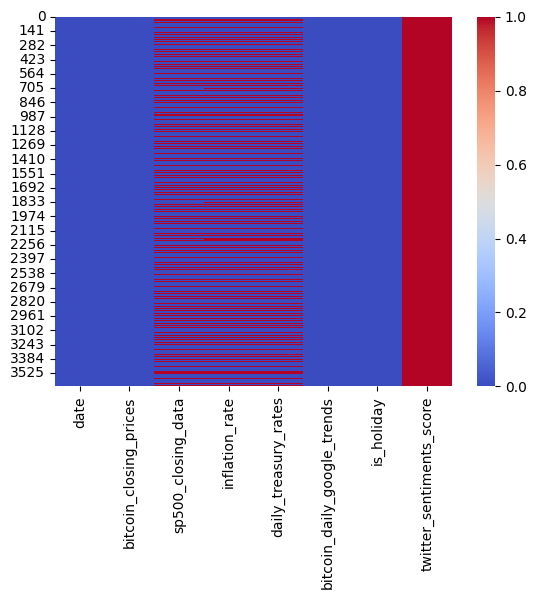

In [41]:
# heatmap of missing values
sns.heatmap(df.isnull(), cmap='coolwarm')

In [42]:
# ffilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='ffill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='ffill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='ffill')

In [43]:
# bfilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns.
# this bfill is for date 01-Nov-2014 and 02-Nov-2014 only as days on these dates are Saturday and Sunday respectively and we have no data to ffill
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='bfill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='bfill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='bfill')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3656 non-null   datetime64[ns]
 1   bitcoin_closing_prices       3655 non-null   float64       
 2   sp500_closing_data           3656 non-null   float64       
 3   inflation_rate               3656 non-null   float64       
 4   daily_treasury_rates         3656 non-null   float64       
 5   bitcoin_daily_google_trends  3656 non-null   int64         
 6   is_holiday                   3656 non-null   int64         
 7   twitter_sentiments_score     0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 228.6 KB


In [45]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                             0      0.00%
bitcoin_closing_prices           1      0.03%
sp500_closing_data               0      0.00%
inflation_rate                   0      0.00%
daily_treasury_rates             0      0.00%
bitcoin_daily_google_trends      0      0.00%
is_holiday                       0      0.00%
twitter_sentiments_score      3656    100.00%


In [46]:
# checking dates where null values are present
df[df['bitcoin_closing_prices'].isnull()]

,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
3655,2024-11-03,NaN,5728.799805,2.33,4.57,52,1,NaN


In [47]:
# dropping rows where bitcoin_closing_prices is null
df = df.dropna(subset=['bitcoin_closing_prices'])

In [48]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                             0      0.00%
bitcoin_closing_prices           0      0.00%
sp500_closing_data               0      0.00%
inflation_rate                   0      0.00%
daily_treasury_rates             0      0.00%
bitcoin_daily_google_trends      0      0.00%
is_holiday                       0      0.00%
twitter_sentiments_score      3655    100.00%


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


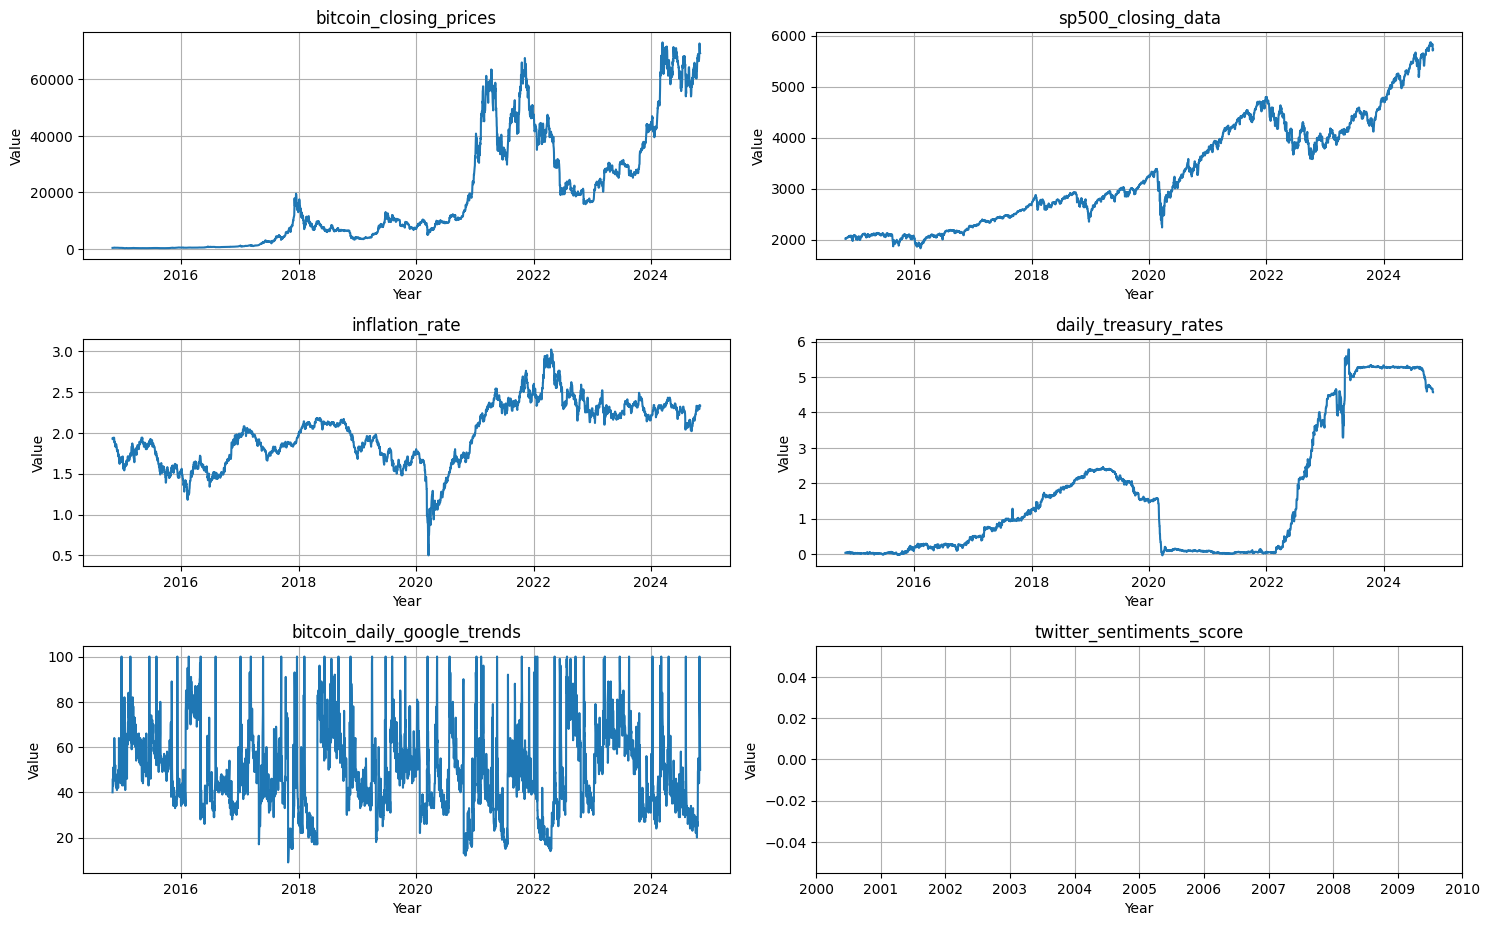

In [49]:
# Define the variables to be plotted
variables = ['bitcoin_closing_prices', 'sp500_closing_data',
             'inflation_rate', 'daily_treasury_rates',
             'bitcoin_daily_google_trends',
             'twitter_sentiments_score']

# Set up the 4x2 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=False)

# Flatten the 2D axes array for easy indexing
axes = axes.flatten()

# Format x-axis to show years
years = mdates.DateFormatter('%Y')

# Plot each variable
for i, col in enumerate(variables):
    axes[i].plot(df['date'], df[col], label=col)
    axes[i].set_title(col, fontsize=12)
    axes[i].xaxis.set_major_formatter(years)  # Set x-axis format
    axes[i].grid(True)
    axes[i].set_ylabel('Value')
    axes[i].set_xlabel('Year')

# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

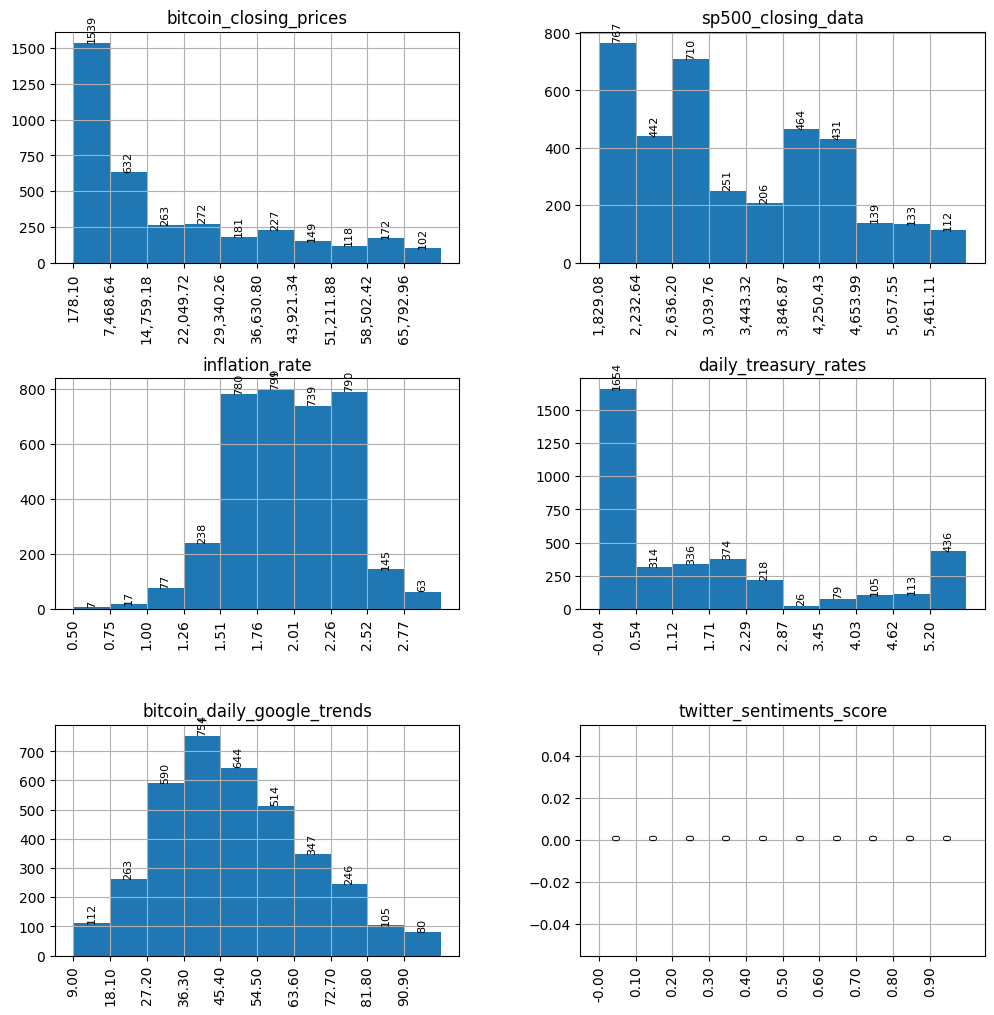

In [50]:
# Plotting histograms of all numerical features
bins=10

df[['bitcoin_closing_prices', 'sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 
    'bitcoin_daily_google_trends', 'twitter_sentiments_score']].hist(bins=bins, figsize=(12, 12))

# displaying count of values above each bar
for ax in plt.gcf().axes:
    for container in ax.containers:
        ax.bar_label(container, rotation=90, fontsize=8)
    
    # Set x-ticks for each bin (using bin edges)
    bin_edges = ax.patches[0].get_x()  # Getting the starting position of the first bin
    bin_width = ax.patches[0].get_width()  # Width of each bin
    ticks = [bin_edges + i * bin_width for i in range(bins)]  # Generate bin centers
    ax.set_xticks(ticks)  # Set ticks on x-axis
    ax.set_xticklabels([f'{tick:,.2f}' for tick in ticks], rotation=90)  # Format labels for better readability
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase vertical and horizontal space
plt.grid(True)
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [51]:
# Import necessary library
from scipy.stats import skew

# Calculate skewness for each column and print results
for column in df[['bitcoin_closing_prices', 'sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 
    'bitcoin_daily_google_trends', 'twitter_sentiments_score']]:
    if column in df.columns:
        column_skewness = skew(df[column].dropna())  # Drop NaNs before calculating skewness
        print(f"Skewness of {column}: {column_skewness:.6f}")
    else:
        print(f"Column {column} not found in the DataFrame!")


Skewness of bitcoin_closing_prices: 1.058494
Skewness of sp500_closing_data: 0.497879
Skewness of inflation_rate: -0.121720
Skewness of daily_treasury_rates: 0.991105
Skewness of bitcoin_daily_google_trends: 0.473198
Skewness of twitter_sentiments_score: nan


In [52]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


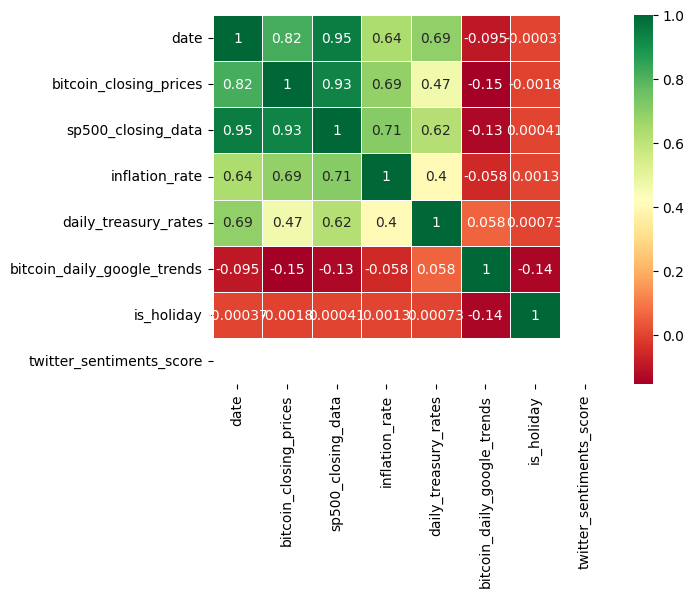

In [53]:
# Example: Plotting a heatmap to show feature correlations

corr = df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True, linewidths=0.5)
plt.show()


In [54]:
corr.map(nf_2)

,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
date,1.00,0.82,0.95,0.64,0.69,-0.09,-0.00,nan
bitcoin_closing_prices,0.82,1.00,0.93,0.69,0.47,-0.15,-0.00,nan
sp500_closing_data,0.95,0.93,1.00,0.71,0.62,-0.13,0.00,nan
inflation_rate,0.64,0.69,0.71,1.00,0.40,-0.06,0.00,nan
daily_treasury_rates,0.69,0.47,0.62,0.40,1.00,0.06,0.00,nan
bitcoin_daily_google_trends,-0.09,-0.15,-0.13,-0.06,0.06,1.00,-0.14,nan
is_holiday,-0.00,-0.00,0.00,0.00,0.00,-0.14,1.00,nan
twitter_sentiments_score,nan,nan,nan,nan,nan,nan,nan,nan


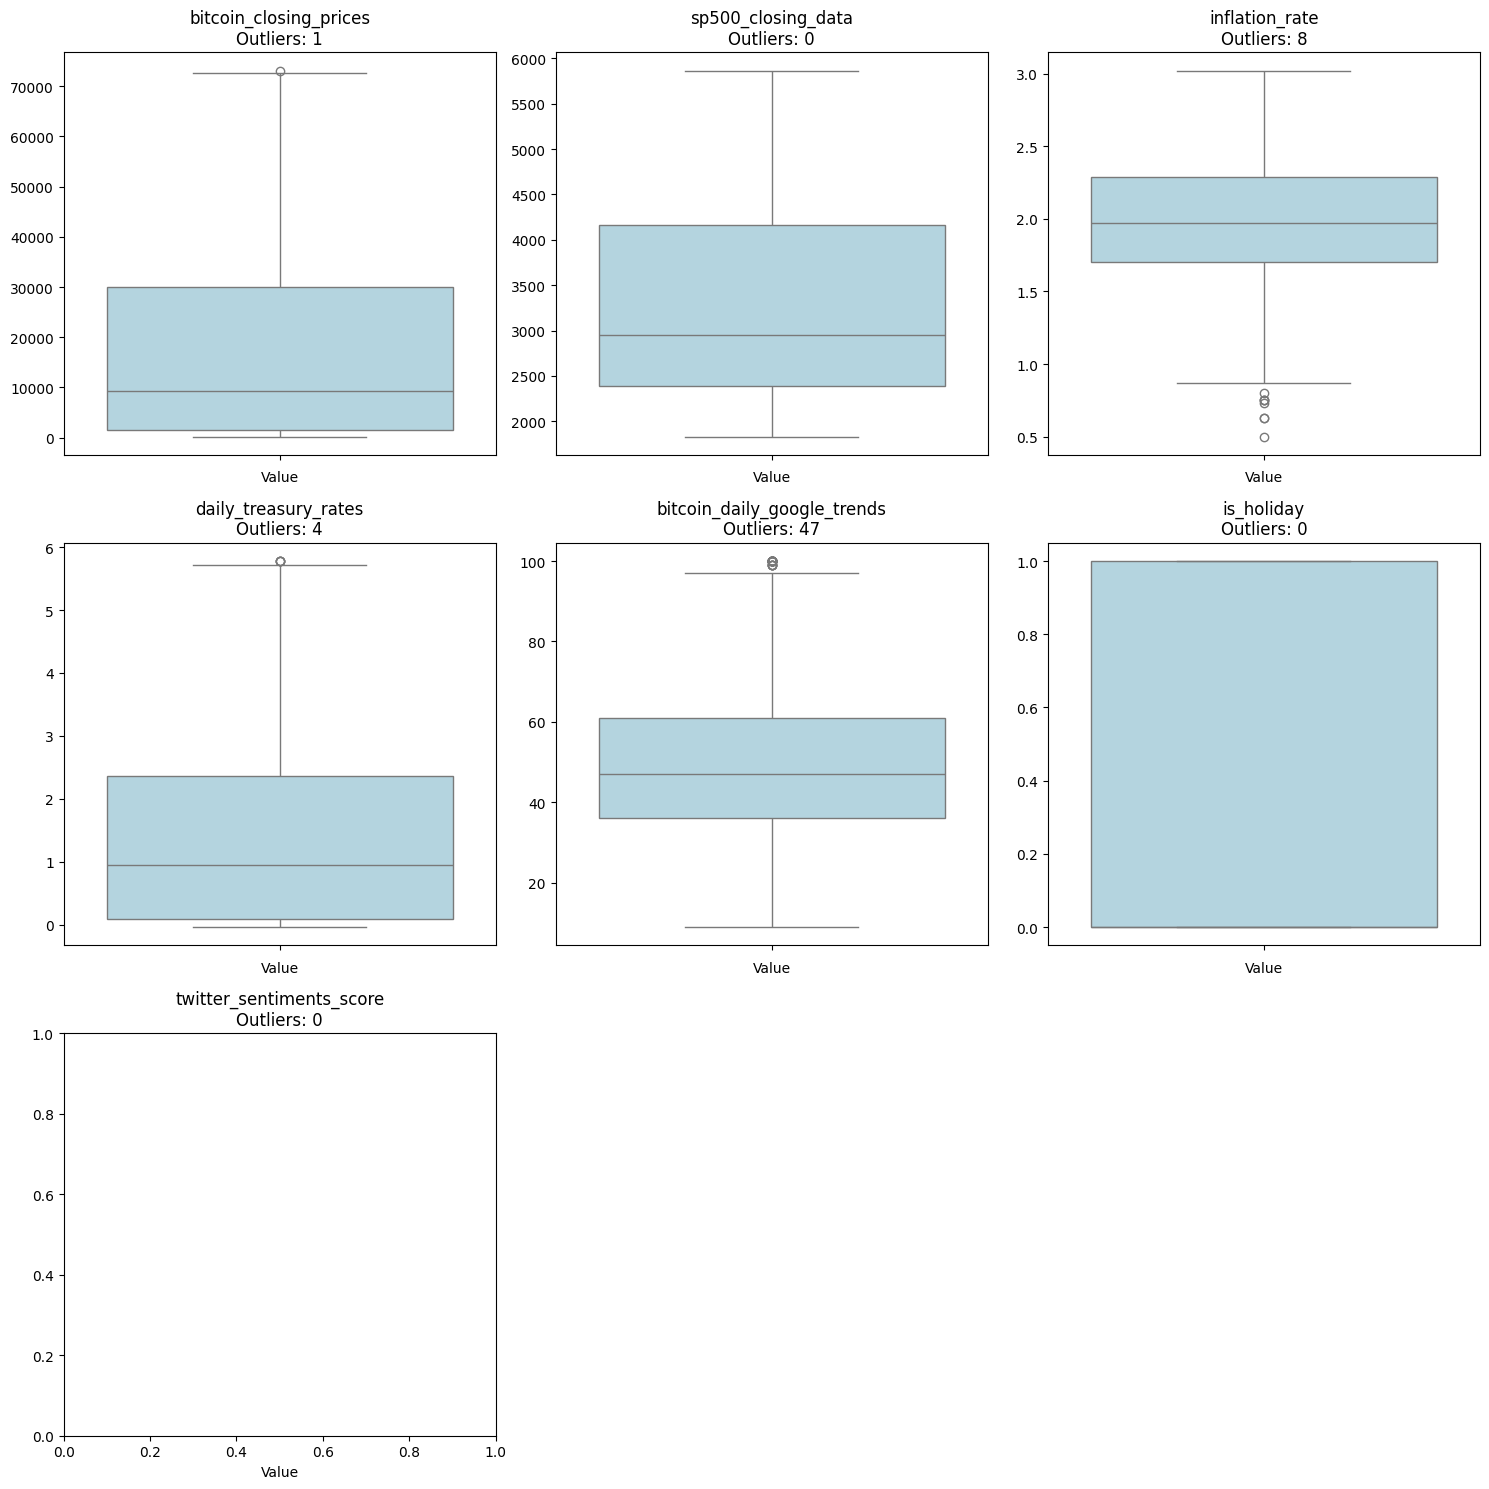

In [55]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound))

# Filter numeric columns only
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Set up the plot grid (4x2 layout)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, col in enumerate(numeric_columns):
    ax = axes[i]
    valid_data = df[col].dropna()  # Drop missing values
    sns.boxplot(y=valid_data, ax=ax, color='lightblue')  # Pass clean data

    # Detect and count outliers
    outliers = detect_outliers_iqr(valid_data)
    num_outliers = outliers.sum()

    # Annotate the plot with the number of outliers
    ax.set_title(f"{col}\nOutliers: {num_outliers}", fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('')

# Hide unused subplots if columns < 8
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

ValueError: x must have 2 complete cycles requires 730 observations. x only has 0 observation(s)

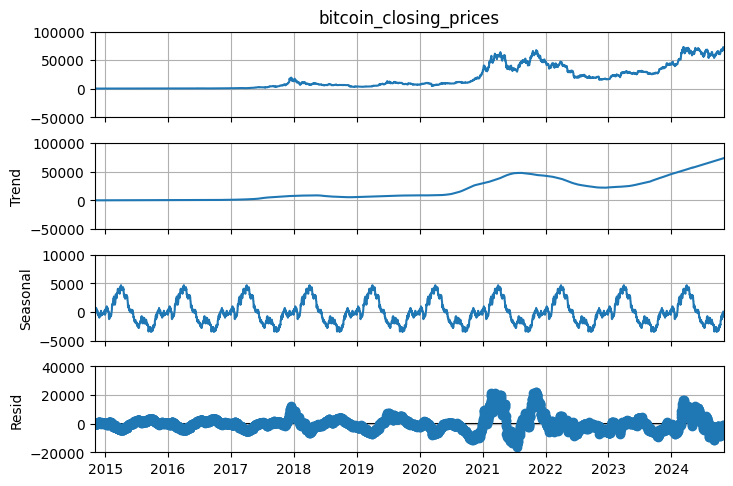

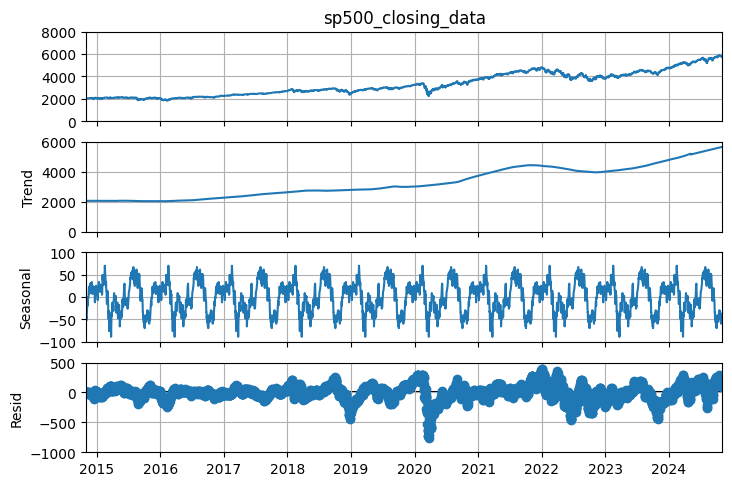

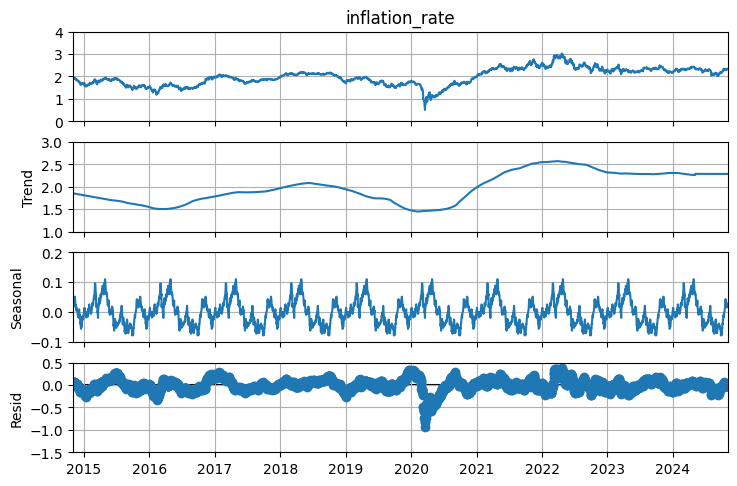

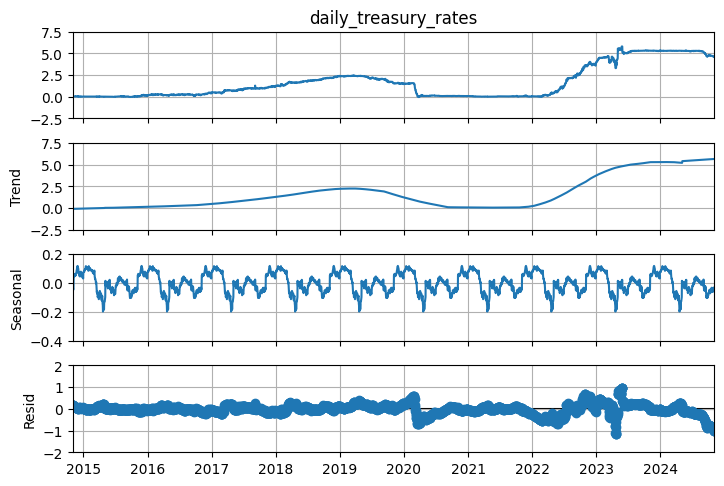

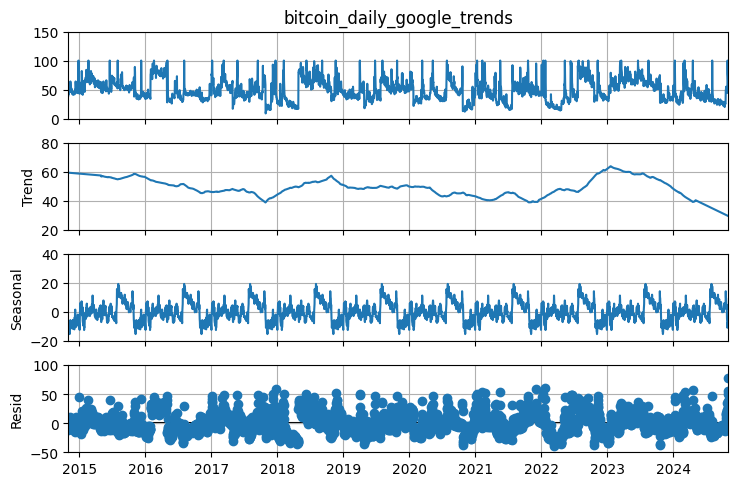

In [56]:
# Ensure 'date' is the datetime index
df.set_index('date', inplace=True)

# Specify the period (assumes daily data with yearly seasonality, adjust as needed)
period = 365

# Iterate through each column to perform seasonal decomposition
for col in ['bitcoin_closing_prices', 'sp500_closing_data', 
            'inflation_rate', 'daily_treasury_rates', 
            'bitcoin_daily_google_trends', 
            'twitter_sentiments_score']:
    
    # Perform seasonal decomposition (additive model, as Multiplicative seasonality is not appropriate for zero and negative values)
    result = seasonal_decompose(df[col].dropna(), model='additive', period=period, extrapolate_trend='freq')
    
    # Plot the decomposition
    fig = result.plot()
    fig.set_size_inches(7.5, 5)  # Adjust figure size
    
    # Get the axes from the figure
    axes = fig.get_axes()

    # Iterate over each subplot axis (observed, trend, seasonal, residual)
    for ax in axes:
        ax.grid(True)  # Enable gridlines for all subplots
        ax.set_yticks(ax.get_yticks())  # Show y-ticks
        
# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

    # Display the plot
    plt.show()

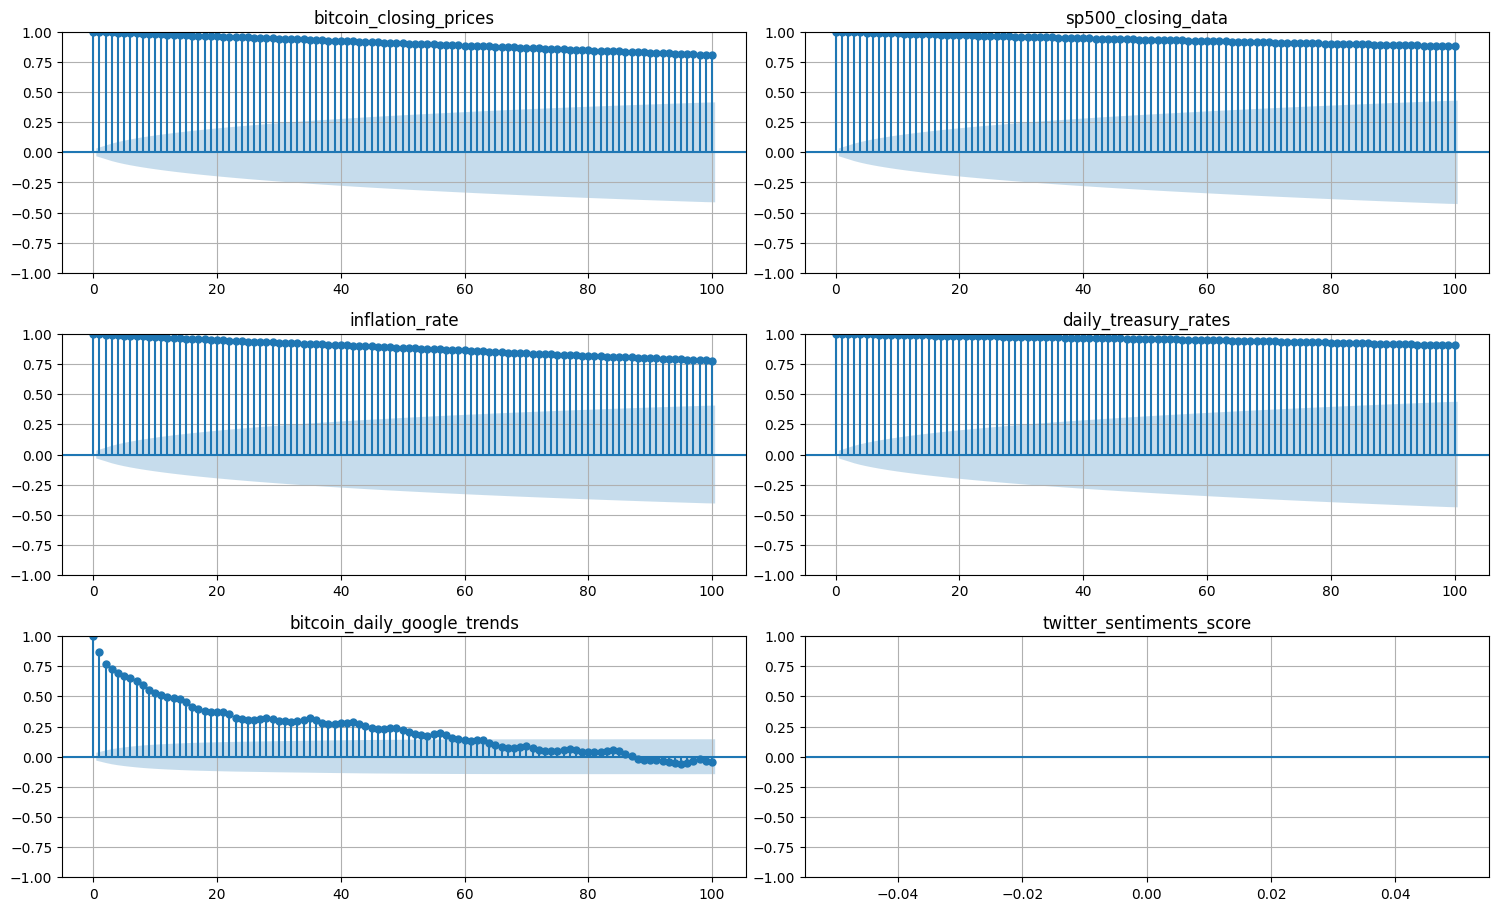

In [61]:
# Define the variables you want to plot ACF for
variables = ['bitcoin_closing_prices', 'sp500_closing_data', 
             'inflation_rate', 'daily_treasury_rates', 
             'bitcoin_daily_google_trends', 'twitter_sentiments_score']

# Create a figure with subplots (4 rows and 2 columns for 8 variables)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through each variable and plot its ACF
for i, col in enumerate(variables):
    # Plot ACF for each variable with 100 lags
    plot_acf(df[col], lags=100, ax=axes[i])
    axes[i].set_title(col, fontsize=12)
    axes[i].grid(True)

# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [59]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# List of variables to test for stationarity
variables = ['bitcoin_closing_prices', 'sp500_closing_data', 
             'inflation_rate', 'daily_treasury_rates', 
             'bitcoin_daily_google_trends']

# Initialize an empty list to store results
adf_results = {}

# Loop through each variable in the DataFrame
for col in variables:
    # Perform Dickey-Fuller test
    dftest = adfuller(df[col], autolag='AIC')

    # Collect all the results from the ADF test
    adf_results[col] = {
        'Test Stats': dftest[0],  # ADF Test Statistic
        'p-value': dftest[1],  # p-value of the test
        'Number of Lags': dftest[2],  # Number of lags used in the test
        'Number of Used Observations': dftest[3],  # Number of observations used
        'Critical Value (1%)': dftest[4]['1%'],  # Critical value for 1% significance level
        'Critical Value (5%)': dftest[4]['5%'],  # Critical value for 5% significance level
        'Critical Value (10%)': dftest[4]['10%'],  # Critical value for 10% significance level
        'H0 Decision': 'Reject' if dftest[1] < 0.05 else 'Accept',  # H0 decision based on p-value
        'Stationary': 'Yes' if dftest[1] < 0.05 else 'No'  # Stationarity based on p-value
    }

# Convert the dictionary into a DataFrame
adf_results_df = pd.DataFrame(adf_results)

# Display the result table
adf_results_df

,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends
Test Stats,-0.618348,0.368779,-1.988891,-0.282852,-6.015863
p-value,0.866782,0.980289,0.291465,0.927898,0.0
Number of Lags,28,14,15,29,27
Number of Used Observations,3626,3640,3639,3625,3627
Critical Value (1%),-3.432155,-3.432148,-3.432148,-3.432155,-3.432154
Critical Value (5%),-2.862337,-2.862334,-2.862335,-2.862338,-2.862337
Critical Value (10%),-2.567194,-2.567193,-2.567193,-2.567195,-2.567194
H0 Decision,Accept,Accept,Accept,Accept,Reject
Stationary,No,No,No,No,Yes


`adf_results_df` contains the results of the Dickey-Fuller test for each variable. It includes the following columns:

- **Test Stats**: The ADF test statistic.
- **p-value**: The p-value of the test.
- **Number of Lags**: The number of lags used in the test.
- **Number of Used Observations**: The number of observations used.
- **Critical Value (1%)**: The critical value for a 1% significance level.
- **Critical Value (5%)**: The critical value for a 5% significance level.
- **Critical Value (10%)**: The critical value for a 10% significance level.
- **H0 Decision**: The decision based on the p-value. If the p-value is less than 0.05, the null hypothesis is rejected, indicating that the time series is non-stationary.
- **Stationary**: The stationarity of the time series based on the p-value. If the p-value is less than 0.05, the time series is considered stationary.

In order to make the data stationary, we need to transform the data. We can do this using the `statsmodels` library. This is done in feature engineering.

In [ ]:
import os
print(os.getcwd())  # This prints the current working directory
df.to_csv('cleaned_data.csv', index=False)